In [1]:
from keras.preprocessing.text import Tokenizer
from gensim.models.fasttext import FastText
import numpy as np
import matplotlib.pyplot as plt
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk import WordPunctTokenizer

import wikipedia
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

%matplotlib inline

Using TensorFlow backend.
[nltk_data] Downloading package punkt to /Users/epanza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/epanza/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/epanza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
artificial_intelligence = wikipedia.page("Artificial Intelligence").content
machine_learning = wikipedia.page("Machine Learning").content
deep_learning = wikipedia.page("Deep Learning").content
neural_network = wikipedia.page("Neural Network").content

artificial_intelligence = sent_tokenize(artificial_intelligence)
machine_learning = sent_tokenize(machine_learning)
deep_learning = sent_tokenize(deep_learning)
neural_network = sent_tokenize(neural_network)

artificial_intelligence.extend(machine_learning)
artificial_intelligence.extend(deep_learning)
artificial_intelligence.extend(neural_network)

In [3]:
import re
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in en_stop]
        tokens = [word for word in tokens if len(word) > 3]

        preprocessed_text = ' '.join(tokens)

        return preprocessed_text

In [4]:
sent = preprocess_text("Artificial intelligence, is the most advanced technology of the present era")
print(sent)


final_corpus = [preprocess_text(sentence) for sentence in artificial_intelligence if sentence.strip() !='']

word_punctuation_tokenizer = nltk.WordPunctTokenizer()
word_tokenized_corpus = [word_punctuation_tokenizer.tokenize(sent) for sent in final_corpus]

artificial intelligence advanced technology present


In [5]:
embedding_size = 60
window_size = 40
min_word = 5
down_sampling = 1e-2

In [6]:
%%time
ft_model = FastText(word_tokenized_corpus,
                      size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=1,
                      iter=100)

CPU times: user 38.6 s, sys: 1.92 s, total: 40.5 s
Wall time: 25.5 s


In [7]:
print(ft_model.wv['artificial'])

[-0.19315986  0.40835384 -0.09531265  0.17810543  0.17987314  0.35346097
 -0.3176813  -0.13754699  0.21292117 -0.16507225  0.39106482  0.35136113
  0.41011083 -0.28830302  0.07783281 -0.02530348  0.03576316 -0.34930375
  0.03860407 -0.17490783 -0.17439146 -0.1755591   0.07297239  0.47461057
  0.06202267  0.52014357  0.01096185 -0.17498167 -0.2632933  -0.45172438
 -0.05072975 -0.2095371  -0.38557968 -0.04959842  0.30265164 -0.1635449
 -0.28598496 -0.28612185  0.28241932  0.16447347 -0.26821262  0.0437891
  0.0603839   0.40556046 -0.41318718  0.21267441  0.14219415  0.33528298
  0.00844085  0.32165387  0.7364237  -0.52598315 -0.33540025  0.40756544
  0.2688131  -0.48044112 -0.04177091  0.29602703 -0.07727817  0.406915  ]


In [8]:
semantically_similar_words = {words: [item[0] for item in ft_model.wv.most_similar([words], topn=5)]
                  for words in ['artificial', 'intelligence', 'machine', 'network', 'recurrent', 'deep']}

for k,v in semantically_similar_words.items():
    print(k+":"+str(v))

artificial:['intelligence', 'inspired', 'moral', 'technology', 'animal']
intelligence:['artificial', 'intelligent', 'technology', 'human', 'simulate']
machine:['learning', 'concerned', 'ethic', 'intelligence', 'nature']
network:['neural', 'deep', 'connectionist', 'layer', 'convolutional']
recurrent:['convolutional', 'rnns', 'sequential', 'short', 'deep']
deep:['network', 'neural', 'speech', 'learning', 'cnns']


In [9]:
print(ft_model.wv.similarity(w1='artificial', w2='intelligence'))

0.82303965


In [10]:
from sklearn.decomposition import PCA

all_similar_words = sum([[k] + v for k, v in semantically_similar_words.items()], [])

print(all_similar_words)
print(type(all_similar_words))
print(len(all_similar_words))

['artificial', 'intelligence', 'inspired', 'moral', 'technology', 'animal', 'intelligence', 'artificial', 'intelligent', 'technology', 'human', 'simulate', 'machine', 'learning', 'concerned', 'ethic', 'intelligence', 'nature', 'network', 'neural', 'deep', 'connectionist', 'layer', 'convolutional', 'recurrent', 'convolutional', 'rnns', 'sequential', 'short', 'deep', 'deep', 'network', 'neural', 'speech', 'learning', 'cnns']
<class 'list'>
36


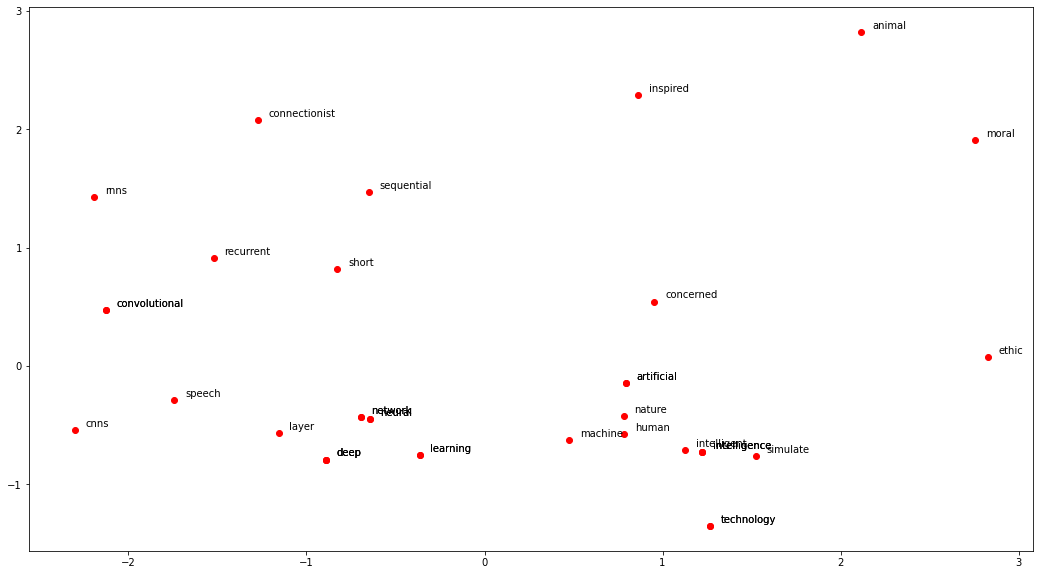

In [11]:
word_vectors = ft_model.wv[all_similar_words]

pca = PCA(n_components=2)

p_comps = pca.fit_transform(word_vectors)
word_names = all_similar_words

plt.figure(figsize=(18, 10))
plt.scatter(p_comps[:, 0], p_comps[:, 1], c='red')

for word_names, x, y in zip(word_names, p_comps[:, 0], p_comps[:, 1]):
    plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [13]:
import pandas as pd
import numpy as np

yelp_reviews = pd.read_csv("yelp_review.csv")

bins = [0,2,5]
review_names = ['negative', 'positive']

yelp_reviews['reviews_score'] = pd.cut(yelp_reviews['stars'], bins, labels=review_names)

yelp_reviews.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,reviews_score
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,positive
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0,positive
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0,positive
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0,positive
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0,positive


Text Classification

In [17]:
import pandas as pd
from io import StringIO
import csv

col = ['reviews_score', 'text']

yelp_reviews = yelp_reviews[col]
yelp_reviews['reviews_score']=['__label__'+ s for s in yelp_reviews['reviews_score']]
yelp_reviews['text']= yelp_reviews['text'].replace('\n',' ', regex=True).replace('\t',' ', regex=True)
yelp_reviews.to_csv(r'yelp_reviews_updated.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

In [18]:
yelp_reviews.head()

,reviews_score,text
0,__label____label__positive,Super simple place but amazing nonetheless. It...
1,__label____label__positive,Small unassuming place that changes their menu...
2,__label____label__positive,Lester's is located in a beautiful neighborhoo...
3,__label____label__positive,Love coming here. Yes the place always needs t...
4,__label____label__positive,Had their chocolate almond croissant and it wa...
